In [1]:
from math import sqrt
import time

import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, preprocessing, model_selection
from sklearn.metrics import mean_squared_error


from activation import fun_dict


In [2]:
def load_dataset():
    
    ''' Загрузка датасета и предобработка данных '''

    x, y = datasets.load_breast_cancer(return_X_y=True)
    x = preprocessing.scale(x)
    y = y.reshape(len(y), 1)
    x_path = 'dat/cancer/'
    return x, y

def rmse(a, b):

    ''' Расчет среднеквадратичного отклонения '''

    return sqrt(mean_squared_error(a, b)) 


In [12]:
class NeuralNetwork:
    """
    Neural Network.
    """
    dim: int  # Dimension of the data (features)
    t: int  # Dimension of the target (labels)
    max_iter: int  # Number of iterations
    neurons: int  # Number of neurons in the input layer
    learning_rate: float  # Step
    # Matrix
    input_weight: np.array
    output_weight: np.array
    bias_input_layer: np.array
    bias_output_layer: np.array
    temp_h: np.array  # Value of the hidden layer before applying activation.
    temp_o: np.array  # Value of the output layer before applying activation.
    # Neuronal functions
    activation = None
    activation_der = None

    def __init__(self, seed=None):
        """
        Fix the random number generator.
        """
        np.random.seed(seed)

    def get_layers(self):
        """
        Feed forward random assignation of the two layers.
        """
        self.get_input_layer()
        self.get_output_layer()

    def get_input_layer(self):
        """
        Weights and bias for the hidden layer.
        """
        self.input_weight = np.random.random((self.dim,
                                              self.neurons)) * 2.0 - 1.0
        # self.bias_input_layer = np.random.random((self.neurons, 1))
        self.bias_input_layer = np.zeros((self.neurons, 1))

    def get_output_layer(self):
        """
        Weight and bias for the output layer.
        """
        self.output_weight = np.random.random((self.neurons, 1))  * 2.0 - 1.0
        # self.bias_output_layer = np.random.random((self.t, 1))
        self.bias_output_layer = np.zeros((self.t, 1))
    def initial(self, x, y,
                max_iter,
                neurons,
                learning_rate,
                neuronal_fun):
        """
        Initialize the neural network layers.
        :param x: numpy.array with data (intances and features).
        :param y: numpy.array with the target to predict.
        :param int max_iter: number of iterations for training.
        :param int neurons: number of neurons in the hidden layer.
        :param float learning_rate: step to add in each iteration.
        :param str neuronal_fun: function for activation functions in 
        """
        self.dim = x.shape[1]
        self.t = y.shape[1]
        self.max_iter = max_iter
        self.neurons = neurons
        self.learning_rate = learning_rate
        self.activation = fun_dict[neuronal_fun]['activation']
        self.activation_der = fun_dict[neuronal_fun]['derivative']
        self.get_layers()
        return self

    def train(self, x, y,
              max_iter: int = 1000,
              neurons: int = 10,
              learning_rate: float = 1.0,
              neuronal_fun='sigmoid'):
        """
        Train the neural network with gradient descent.
        :param x: numpy.array with data (intances and features).
        :param y: numpy.array with the target to predict.
        :param int max_iter: number of iterations for training.
        :param int neurons: number of neurons in the hidden layer.
        :param float learning_rate: step to add in each iteration.
        :param str neuronal_fun: function for activation functions in 
        """
        self.initial(x=x,
                     y=y,
                     max_iter=max_iter,
                     neurons=neurons,
                     learning_rate=learning_rate,
                     neuronal_fun=neuronal_fun)

        for iteration in range(self.max_iter):
            # print('Iteration =', iteration)
            self.backward(x, y)

    def backward(self, x, y, penalty):
        """
        Back propagation formula with a penalty.
        :param x:
        :param y:
        :param penalty:
        :return:
        """
        hidden_layer, output_layer = self.forward(x)
        error = output_layer - y
        # print('Error =', np.linalg.norm(error), ', NC penalty =', np.linalg.norm(penalty))
        nc_error = error + penalty

        # Output layer
        output_delta = nc_error * self.activation_der(self.temp_o)
        # print('Norm of the gradient of output layer =', np.linalg.norm(output_delta))
        self.bias_output_layer -= np.mean(self.learning_rate * output_delta)
        self.output_weight -= self.learning_rate * np.dot(hidden_layer.T, output_delta)

        # Hidden layer
        hidden_delta = np.dot(output_delta, self.output_weight.T) * self.activation_der(self.temp_h)
        # print('Norm of the gradient of hidden layer =', np.linalg.norm(hidden_delta))
        self.bias_input_layer -= np.mean(self.learning_rate * hidden_delta, axis=0).reshape(self.neurons, 1)
        self.input_weight -= self.learning_rate * np.dot(x.T, hidden_delta)

    def forward(self, x_test):
        self.temp_h = np.dot(x_test, self.input_weight) + self.bias_input_layer.T
        hidden_layer = self.activation(self.temp_h)
        self.temp_o = np.dot(hidden_layer, self.output_weight) + self.bias_output_layer.T
        output_layer = self.activation(self.temp_o)
        return hidden_layer, output_layer


    def predict(self, x_test):
        _, output_layer = self.forward(x_test)
        return output_layer

class NCL:
    
    ''' Negative Correlation Learning ensemble '''

    size: int
    max_iter: int
    lambda_: float
    learning_rate: float
    base_learner = list
    rmse_array: np.array

    def train(self, x, y, size, neurons, max_iter, lambda_, learning_rate, neural_fun='sigmoid'):
        
        '''
        Обучение ансамбля
        - параметр x: данные
        - параметр y: метка
        - параметр size: кол-во обучаемых моделей
        - параметр neurons: кол-во нейронов
        - параметр max_iter: кол-во эпох
        - параметр lambda_: 
        - параметр learning_rate: скорость обучения
        - параметр neural_fun: функция активации
        '''

        # Parameter
        self.size = size
        self.max_iter = max_iter
        self.lambda_ = lambda_
        self.base_learner = [NeuralNetwork(seed=s).initial(x=x,
                                                           y=y,
                                                           neurons=neurons,
                                                           learning_rate=learning_rate,
                                                           neuronal_fun=neural_fun,
                                                           max_iter=max_iter)
                             for s in range(self.size)]
        
        # Saving RMSE in training
        self.rmse_array = np.inf * np.ones(self.max_iter)
        #weights = []

        # Обучение
        for iteration in range(self.max_iter):  # Each epoch
            #print('Iteration =', iteration)
            f_bar = self.predict(x)
            for s in range(self.size):  # Each base learner
                penalty = - self.lambda_ * (self.base_learner[s].predict(x) - f_bar)
                self.base_learner[s].backward(x, y, penalty)
                # print()
            # print()
            self.rmse_array[iteration] = rmse(f_bar, y)
        
        #for i in range(len(self.base_learner)):
        #    weights.append(self.base_learner[i].input_weight)
        #    weights.append(self.base_learner[i].output_weight)
        #    weights.append(self.base_learner[i].bias_input_layer)
        #    weights.append(self.base_learner[i].bias_output_layer)
#
        #MyFile=open('weights.txt', 'w+')
        #for element in weights:
        #    MyFile.write(str(element))
        #    MyFile.write('\n')
        #MyFile.close()
            
    def predict(self, x):
        """
        :param x:
        :return: f_bar
        """
        f_bar = np.mean([self.base_learner[s].predict(x) for s in range(self.size)],
                        axis=0)
        return f_bar

Train =  341
Test =  228
Colums =  30
Lambda =  0
RMSE = 0.30511764762170995
Время обучения = 6.067964300047606
Время отклика = 0.0005552000366151333


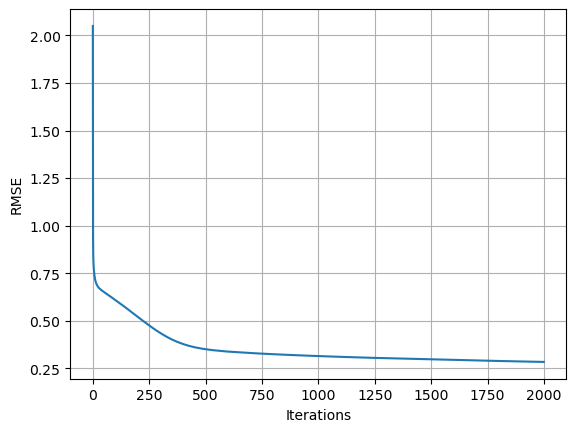

In [13]:

# Загрузка датасета и формирование выборок
x, y = load_dataset()
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size= 0.4, random_state=0)
print('Train = ',  x_train.shape[0])
print('Test = ',   x_test.shape[0])
print('Colums = ', x_train.shape[1])

# Параметры обучения
max_iter = 2000
size = 10
h = 10                  # Количество нейронов в скрытом слое
lambda_ = 0
learning_rate = 0.001   # Скорость обучения
print('Lambda = ', lambda_)

# Создание ансамбля моделей
model = NCL()

# Обучение
train_time_start = time.perf_counter()
model.train(x_train, y_train, size, h, max_iter, lambda_, learning_rate, neural_fun='leaky_relu')
train_time_end = time.perf_counter()

# Тестирование
test_time_start = time.perf_counter()
pred = model.predict(x_test)
test_time_end = time.perf_counter()

# RMSE
rmse_value = rmse(pred, y_test)
print('RMSE =', rmse_value)

# Время обучения
print('Время обучения =', train_time_end - train_time_start)
print('Время отклика =', test_time_end - test_time_start)

# Кривая обучения 
plt.plot(model.rmse_array)
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.grid()
plt.show()

Train =  341
Test =  228
Colums =  30
Lambda =  1
LOADED RMSE = 0.14163742530938636
RMSE = 0.14163742530938636
Время обучения = 3.027739899989683
Время отклика = 0.0009231999865733087


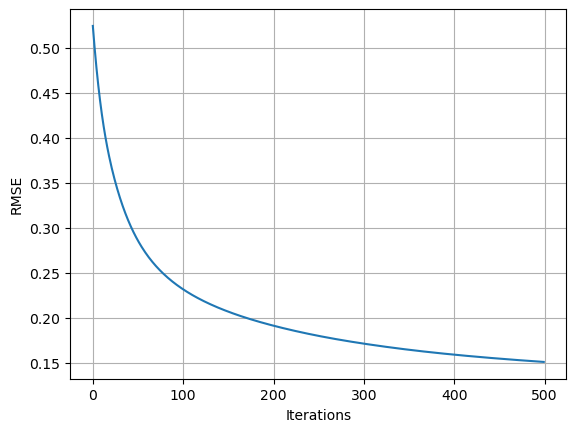

In [43]:
import numpy as np
import pickle
from graphviz import Digraph
class NeuralNetwork:
    """
    Neural Network.
    """
    def __init__(self, seed=None):
        np.random.seed(seed)

    def get_layers(self):
        self.get_input_layer()
        self.get_output_layer()

    def get_input_layer(self):
        self.input_weight = np.random.random((self.dim, self.neurons)) * 2.0 - 1.0
        self.bias_input_layer = np.zeros((self.neurons, 1))

    def get_output_layer(self):
        self.output_weight = np.random.random((self.neurons, 1))  * 2.0 - 1.0
        self.bias_output_layer = np.zeros((self.t, 1))

    def initial(self, x, y, max_iter, neurons, learning_rate, neuronal_fun, fun_dict):
        self.dim = x.shape[1]
        self.t = y.shape[1]
        self.max_iter = max_iter
        self.neurons = neurons
        self.learning_rate = learning_rate
        self.activation = fun_dict[neuronal_fun]['activation']
        self.activation_der = fun_dict[neuronal_fun]['derivative']
        self.get_layers()
        return self

    def train(self, x, y, max_iter=500, neurons=5, learning_rate=0.01, neuronal_fun='sigmoid', fun_dict=None):
        self.initial(x=x, y=y, max_iter=max_iter, neurons=neurons, learning_rate=learning_rate, neuronal_fun=neuronal_fun, fun_dict=fun_dict)
        for iteration in range(self.max_iter):
            self.backward(x, y)

    #def backward(self, x, y, penalty=0):
    #    hidden_layer, output_layer = self.forward(x)
    #    error = output_layer - y
    #    nc_error = error + penalty
#
    #    output_delta = nc_error * self.activation_der(self.temp_o)
    #    self.bias_output_layer -= np.mean(self.learning_rate * output_delta)
    #    self.output_weight -= self.learning_rate * np.dot(hidden_layer.T, output_delta)
#
    #    hidden_delta = np.dot(output_delta, self.output_weight.T) * self.activation_der(self.temp_h)
    #    self.bias_input_layer -= np.mean(self.learning_rate * hidden_delta, axis=0).reshape(self.neurons, 1)
    #    self.input_weight -= self.learning_rate * np.dot(x.T, hidden_delta)
#
    #def forward(self, x_test):
    #    self.temp_h = np.dot(x_test, self.input_weight) + self.bias_input_layer.T
    #    hidden_layer = self.activation(self.temp_h)
    #    self.temp_o = np.dot(hidden_layer, self.output_weight) + self.bias_output_layer.T
    #    output_layer = self.activation(self.temp_o)
    #    return hidden_layer, output_layer

    def backward(self, x, y, penalty):
        """
        Back propagation formula with a penalty.
        :param x:
        :param y:
        :param penalty:
        :return:
        """
        hidden_layer, output_layer = self.forward(x)
        error = output_layer - y
        # print('Error =', np.linalg.norm(error), ', NC penalty =', np.linalg.norm(penalty))
        nc_error = error + penalty

        # Output layer
        output_delta = nc_error * self.activation_der(self.temp_o)
        # print('Norm of the gradient of output layer =', np.linalg.norm(output_delta))
        self.bias_output_layer -= np.mean(self.learning_rate * output_delta)
        self.output_weight -= self.learning_rate * np.dot(hidden_layer.T, output_delta)

        # Hidden layer
        hidden_delta = np.dot(output_delta, self.output_weight.T) * self.activation_der(self.temp_h)
        # print('Norm of the gradient of hidden layer =', np.linalg.norm(hidden_delta))
        self.bias_input_layer -= np.mean(self.learning_rate * hidden_delta, axis=0).reshape(self.neurons, 1)
        self.input_weight -= self.learning_rate * np.dot(x.T, hidden_delta)

    def forward(self, x_test):
        self.temp_h = np.dot(x_test, self.input_weight) + self.bias_input_layer.T
        hidden_layer = self.activation(self.temp_h)
        self.temp_o = np.dot(hidden_layer, self.output_weight) + self.bias_output_layer.T
        output_layer = self.activation(self.temp_o)
        return hidden_layer, output_layer


    def predict(self, x_test):
        _, output_layer = self.forward(x_test)
        return output_layer

    def predict(self, x_test):
        _, output_layer = self.forward(x_test)
        return output_layer

    def save_model(self, file_path):
        with open(file_path, 'wb') as f:
            pickle.dump(self, f)

    @staticmethod
    def load_model(file_path):
        with open(file_path, 'rb') as f:
            return pickle.load(f)
        
    

class NCL:
    def __init__(self):
        self.base_learner = []
        self.rmse_array = None

    def visualize(self, file_path='ncl_ensemble', node_size=0.1, graph_size=100, horizontal_spacing=10):
        dot = Digraph()

        # Горизонтальное расположение
        dot.attr(rankdir='LR')
        dot.attr(size=f'{graph_size},{graph_size}!')
        
        # Установка расстояния между графами по горизонтали
        dot.attr(ranksep=str(horizontal_spacing))

        for i, learner in enumerate(self.base_learner):
            dot.node(f'Learner {i}', label=f'Learner {i}', shape='ellipse')
            learner_dot = Digraph()

            # Горизонтальное расположение
            learner_dot.attr(rankdir='LR')

            # Input layer
            for j in range(learner.dim):
                learner_dot.node(f'Input {j}', shape='circle', width=str(node_size), height=str(node_size))

            # Hidden layer
            for k in range(learner.neurons):
                learner_dot.node(f'Hidden {k}', shape='circle', width=str(node_size), height=str(node_size))

            # Output layer
            learner_dot.node('Output', shape='circle', width=str(node_size), height=str(node_size))

            # Input to hidden layer connections
            for j in range(learner.dim):
                for k in range(learner.neurons):
                    learner_dot.edge(f'Input {j}', f'Hidden {k}', label=f'{learner.input_weight[j, k]:.2f}')

            # Hidden to output layer connections
            for k in range(learner.neurons):
                learner_dot.edge(f'Hidden {k}', 'Output', label=f'{learner.output_weight[k, 0]:.2f}')

            learner_dot.render(f'{file_path}_learner_{i}', format='png', cleanup=True)
            dot.subgraph(learner_dot)

        dot.render(file_path, format='png', cleanup=True)
    
    def train(self, x, y, size, neurons, max_iter, lambda_, learning_rate, neural_fun='sigmoid', fun_dict=None):
        self.size = size
        self.max_iter = max_iter
        self.lambda_ = lambda_
        self.base_learner = [NeuralNetwork(seed=s).initial(x=x, y=y, neurons=neurons, learning_rate=learning_rate, neuronal_fun=neural_fun, max_iter=max_iter, fun_dict=fun_dict)
                             for s in range(self.size)]

        self.rmse_array = np.inf * np.ones(self.max_iter)

        #for iteration in range(self.max_iter):
        #    f_bar = self.predict(x)
        #    for s in range(self.size):
        #        penalty = - self.lambda_ * (self.base_learner[s].predict(x) - f_bar)
        #        self.base_learner[s].backward(x, y, penalty)
        #    self.rmse_array[iteration] = np.sqrt(np.mean((f_bar - y) ** 2))

        # Обучение
        for iteration in range(self.max_iter):  # Each epoch
            #print('Iteration =', iteration)
            f_bar = self.predict(x)
            for s in range(self.size):  # Each base learner
                penalty = - self.lambda_ * (self.base_learner[s].predict(x) - f_bar)
                self.base_learner[s].backward(x, y, penalty)
                # print()
            # print()
            self.rmse_array[iteration] = rmse(f_bar, y)

    def predict(self, x):
        f_bar = np.mean([learner.predict(x) for learner in self.base_learner], axis=0)
        return f_bar

    def save_model(self, file_path):
        with open(file_path, 'wb') as f:
            pickle.dump(self, f)

    @staticmethod
    def load_model(file_path):
        with open(file_path, 'rb') as f:
            return pickle.load(f)

# Загрузка датасета и формирование выборок
x, y = load_dataset()
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size= 0.4, random_state=0)
print('Train = ',  x_train.shape[0])
print('Test = ',   x_test.shape[0])
print('Colums = ', x_train.shape[1])

# Параметры обучения
max_iter = 500
size = 10
h = 10                  # Количество нейронов в скрытом слое
lambda_ = 1
learning_rate = 0.001   # Скорость обучения
print('Lambda = ', lambda_)

ncl = NCL()
train_time_start = time.perf_counter()
ncl.train(x, y, size=size, neurons=h, max_iter=max_iter, lambda_= lambda_, learning_rate=learning_rate, neural_fun='sigmoid', fun_dict=fun_dict)
train_time_end = time.perf_counter()
ncl.save_model('ncl_ensemble.pkl')

# Загрузка модели
loaded_ncl = NCL.load_model('ncl_ensemble.pkl')

#ncl.visualize('ncl_ensemble.pkl')

# Тестирование
#test_time_start = time.perf_counter()
# Тестирование
test_time_start = time.perf_counter()
pred = ncl.predict(x_test)
test_time_end = time.perf_counter()
ncl_predictions = loaded_ncl.predict(x_test)
#test_time_end = time.perf_counter()

# RMSE
loaded_rmse_value = rmse(ncl_predictions, y_test)
rmse_value = rmse(pred, y_test)
print('LOADED RMSE =', loaded_rmse_value)
print('RMSE =', rmse_value)

# Время обучения
print('Время обучения =', train_time_end - train_time_start)
print('Время отклика =', test_time_end - test_time_start)

# Кривая обучения 
plt.plot(ncl.rmse_array)
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.grid()
plt.show()

LOADED RMSE = 0.039960598493503106
RMSE = 0.039960598493503106
Время обучения = 15.125246899959166
Время отклика = 0.0014230999513529241


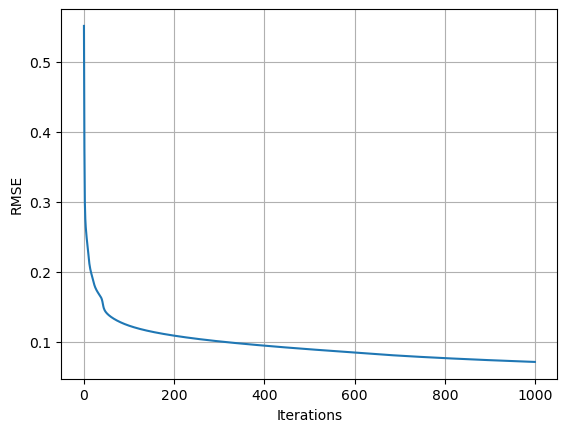

In [48]:
# Параметры обучения
max_iter = 1000  # Увеличим количество итераций
size = 10
h = 50            # Попробуем увеличить количество нейронов в скрытом слое
lambda_ = 1
learning_rate = 0.01  # Уменьшим скорость обучения

ncl1 = NCL()
ncl2 = NCL()
ncl1.train(x, y, size=size, neurons=h, max_iter=max_iter, lambda_= 0, learning_rate=learning_rate, neural_fun='sigmoid', fun_dict=fun_dict)
ncl2.train(x, y, size=size, neurons=h, max_iter=max_iter, lambda_= 1, learning_rate=learning_rate, neural_fun='sigmoid', fun_dict=fun_dict)

pred1 = ncl1.predict(x_test)
pred2 = ncl2.predict(x_test)

# RMSE
rmse_value1 = rmse(pred1, y_test)
rmse_value2 = rmse(pred2, y_test)
print('RMSE lambda = 0:', rmse_value1)
print('RMSE lambda = 1:', rmse_value2)


# Кривая обучения 
plt.plot(ncl.rmse_array)
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.grid()
plt.show()